# Sentiment Analysis IKN Article News




In [10]:
# Install required packages
!pip install pandas emoji langdetect scikit-learn regex matplotlib seaborn wordcloud -q

import pandas as pd
import re
import emoji
import string
import logging
from langdetect import detect, LangDetectException
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# from google.colab import files
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [11]:
# Inisialisasi logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [12]:
import pandas as pd
import logging

# --- setup logger biar ada pesan di terminal ---
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# --- baca dataset lebih dulu ---
filename = "/Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA_AnalisisSentimenIKN-main/dataset_gojek_final.csv"      # sesuaikan dengan nama file kamu
gojek_news_df = pd.read_csv(filename)
logger.info(f"Dataset {filename} dimuat dengan {len(gojek_news_df)} baris.")

# --- baru lakukan validasi kolom ---
required_columns = ['judul', 'content', 'tanggal']
if not all(col in gojek_news_df.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in gojek_news_df.columns]
    logger.error(f"Kolom yang hilang: {missing_cols}")
    raise ValueError(f"DataFrame harus memiliki kolom: {required_columns}")
else:
    logger.info("✅ Semua kolom yang dibutuhkan tersedia.")


2025-10-28 15:57:52,412 - INFO - Dataset /Users/irfan/Documents/0. KULIAH/SEMESTER 7/PBA/FP_PBA_AnalisisSentimenIKN-main/dataset_gojek_final.csv dimuat dengan 177 baris.
2025-10-28 15:57:52,416 - INFO - ✅ Semua kolom yang dibutuhkan tersedia.


In [15]:
# === KONFIGURASI AWAL UNTUK GOJEK ===

# Jumlah data awal
initial_count = len(gojek_news_df)

# Akronim atau singkatan penting yang perlu dipertahankan
important_acronyms = [
    'Gojek', 'GoPay', 'GoSend', 'GoFood', 'GoRide', 'GoCar', 
    'GoBox', 'GoMart', 'GoCorp', 'GoBiz', 'GoPlay', 'GoTix', 'GoTransit', 'GOTO'
]

# Kata kunci utama terkait Gojek dan ekosistem digitalnya
gojek_keywords = [
    'gojek', 'grab', 'goto', 'gopay', 'goride', 'gocar', 'gofood', 'gosend',
    'driver ojol', 'ojek online', 'aplikasi', 'startup', 'teknologi', 'digital', 
    'transportasi', 'ride hailing', 'layanan pesan antar', 'mitra', 'pengemudi',
    'tarif', 'komisi', 'subsidi', 'investasi', 'ekonomi digital', 'promosi'
]

# Kamus normalisasi kata informal (umum di media sosial/berita)
normalization_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak', 'kagak': 'tidak',
    'bgt': 'banget', 'bener': 'benar', 'drivernya': 'driver', 'ojolnya': 'ojol',
    'gocar': 'GoCar', 'goride': 'GoRide', 'gojek': 'Gojek', 'grab': 'Grab', 
    'gopay': 'GoPay', 'gosend': 'GoSend', 'gofood': 'GoFood', 
    'goto': 'GoTo', 'tokopedia': 'Tokopedia', 'gopulsa': 'GoPulsa', 
    'app': 'aplikasi', 'appnya': 'aplikasi', 'pengendara': 'driver', 
    'penumpang': 'customer', 'ojek': 'ojol', 'ojol': 'ojol'
}

# Pola teks yang tidak relevan (disingkirkan dengan regex)
patterns_to_remove = [
    r'©\s*copyright\s*\d{4}.*?(?:all rights? reserved)?',
    r'baca juga\s*:.*', r'scroll to continue.*', r'klik disini.*',
    r'sumber\s*:\s*[a-zA-Z0-9\s\.\-]+', r'editor\s*:\s*[a-zA-Z\s]+',
    r'reporter\s*:\s*[a-zA-Z\s]+', r'lokasi\s*:\s*[a-zA-Z\s]+',
    r'follow akun.*(instagram|facebook|tiktok).*', 
    r'download aplikasi.*(play store|app store).*'
]

# Teks-teks noise yang sering muncul di portal berita Indonesia
texts_to_remove = [
    "baca juga", "klik di sini", "copyright", "all rights reserved", 
    "berita terkait", "baca selengkapnya", "editor", "reporter", 
    "simak video berikut", "ikuti kami di", "follow akun kami", 
    "scroll ke bawah untuk membaca", "sumber: gojek", "sumber: grab",
    "foto: dok gojek", "dok gojek", "dok grab", "liputan gojek", 
    "© gojek", "© grab", "© goto", "tempo.co", "tribunnews.com", "cnnindonesia.com",
    "kompas.com", "detik.com", "suara.com", "antaranews.com", "inews.id"
]


In [16]:
# Fungsi preprocessing terintegrasi
def preprocess_text(text):
    try:
        # Standarisasi akronim
        for acronym in important_acronyms:
            text = re.sub(rf'(?i)\b{acronym}\b', acronym, str(text))

        # Hapus emoji dan karakter khusus
        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'[^\w\s.,!?éê]', '', text)

        # Normalisasi teks
        for slang, formal in normalization_dict.items():
            text = re.sub(rf'\b{slang}\b', formal, text, flags=re.IGNORECASE)
        text = re.sub(r',(?!\s)', ', ', text)
        text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', '')
        text = re.sub(r'(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?|(bit\.ly|tinyurl\.com|t\.co)\/[^\s\r\n]*', '', text)
        text = re.sub(r'\b\d{1,3}\b(?!\s*(?:miliar|triliun|hektar|tahun))', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation.replace(',', '').replace('.', '')))
        text = re.sub(r'\s+', ' ', text).strip()

        # Hapus teks tidak relevan
        for pattern in patterns_to_remove:
            text = re.sub(pattern, '', text)
        for text_to_remove in texts_to_remove:
            text = text.replace(text_to_remove, '')

        # Lowercasing dengan pengecualian
        for acronym in important_acronyms:
            text = re.sub(rf'\b{acronym}\b', f'__{acronym}__', text, flags=re.IGNORECASE)
        text = text.lower()
        for acronym in important_acronyms:
            text = text.replace(f'__{acronym}__', acronym)

        return text
    except Exception as e:
        logger.error(f"Error in preprocess_text: {e}")
        return text

In [17]:
# Fungsi deteksi bahasa dan relevansi
def is_valid_text(text):
    try:
        # Deteksi bahasa
        is_id = detect(text) == 'id' or any(keyword.lower() in text.lower() for keyword in gojek_keywords)
        # Cek relevansi (minimal 2 kata kunci)
        keyword_count = sum(1 for keyword in gojek_keywords if keyword.lower() in text.lower())
        return is_id and keyword_count >= 2
    except LangDetectException:
        logger.warning(f"Language detection failed for text: {text[:50]}...")
        return any(keyword.lower() in text.lower() for keyword in gojek_keywords) and sum(1 for keyword in gojek_keywords if keyword.lower() in text.lower()) >= 2
    except Exception as e:
        logger.error(f"Error in is_valid_text: {e}")
        return False

In [18]:
# Fungsi hapus duplikasi berdasarkan konten
def remove_duplicates(df):
    try:
        vectorizer = TfidfVectorizer(max_features=5000)
        tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'].fillna(''))
        cosine_sim = cosine_similarity(tfidf_matrix)
        indices_to_remove = set()
        for i in range(len(cosine_sim)):
            for j in range(i + 1, len(cosine_sim)):
                if cosine_sim[i][j] > 0.9:
                    indices_to_remove.add(j)
        return df.drop(index=indices_to_remove).reset_index(drop=True)
    except Exception as e:
        logger.error(f"Error in remove_duplicates: {e}")
        return df

In [19]:
# Proses preprocessing utama
logger.info("Memulai preprocessing sebelum augmentasi...")
gojek_news_df['tanggal'] = pd.to_datetime(gojek_news_df['tanggal'], errors='coerce')
gojek_news_df = gojek_news_df.dropna(subset=['content'])  # Hapus baris dengan konten kosong

# Terapkan preprocessing
logger.info("Menerapkan preprocessing pada teks...")
gojek_news_df['cleaned_content'] = gojek_news_df['content'].apply(preprocess_text)
gojek_news_df['judul'] = gojek_news_df['judul'].apply(preprocess_text)

# Hapus duplikasi
logger.info("Menghapus duplikasi berdasarkan konten...")
gojek_news_df = remove_duplicates(gojek_news_df)
logger.info(f"Jumlah data setelah menghapus duplikasi: {len(gojek_news_df)}")

# Filter teks valid
logger.info("Memfilter teks berdasarkan bahasa dan relevansi...")
gojek_news_df = gojek_news_df[gojek_news_df['cleaned_content'].apply(is_valid_text)]
logger.info(f"Jumlah data setelah filter bahasa dan relevansi: {len(gojek_news_df)}")

# Analisis tambahan
logger.info("Melakukan analisis tambahan...")
gojek_news_df['tahun'] = gojek_news_df['tanggal'].dt.year
valid_dates = gojek_news_df.dropna(subset=['tanggal'])
if not valid_dates.empty:
    min_date = valid_dates['tanggal'].min()
    max_date = valid_dates['tanggal'].max()
    logger.info(f"Rentang tanggal berita: {min_date.strftime('%d-%m-%Y')} hingga {max_date.strftime('%d-%m-%Y')}")
else:
    logger.warning("Tidak ada data dengan tanggal valid.")

berita_per_tahun = gojek_news_df['tahun'].value_counts().sort_index()
logger.info("Distribusi berita per tahun:")
logger.info(berita_per_tahun.to_string())

2025-10-28 15:58:17,332 - INFO - Memulai preprocessing sebelum augmentasi...
2025-10-28 15:58:17,364 - INFO - Menerapkan preprocessing pada teks...
2025-10-28 15:58:17,938 - INFO - Menghapus duplikasi berdasarkan konten...
2025-10-28 15:58:17,979 - INFO - Jumlah data setelah menghapus duplikasi: 158
2025-10-28 15:58:17,979 - INFO - Memfilter teks berdasarkan bahasa dan relevansi...
2025-10-28 15:58:18,510 - INFO - Jumlah data setelah filter bahasa dan relevansi: 143
2025-10-28 15:58:18,510 - INFO - Melakukan analisis tambahan...
2025-10-28 15:58:18,516 - INFO - Rentang tanggal berita: 01-06-2018 hingga 02-10-2025
2025-10-28 15:58:18,521 - INFO - Distribusi berita per tahun:
2025-10-28 15:58:18,522 - INFO - tahun
2018.0     3
2019.0     1
2020.0     1
2021.0     3
2022.0     1
2023.0    11
2024.0    19
2025.0    32


2025-10-28 15:58:35,715 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/77/vv2j_079111byz0tpny0xplc0000gp/T/ipykernel_2630/1852670857.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=berita_per_tahun.index, y=berita_per_tahun.values, palette='viridis')
2025-10-28 15:58:35,721 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


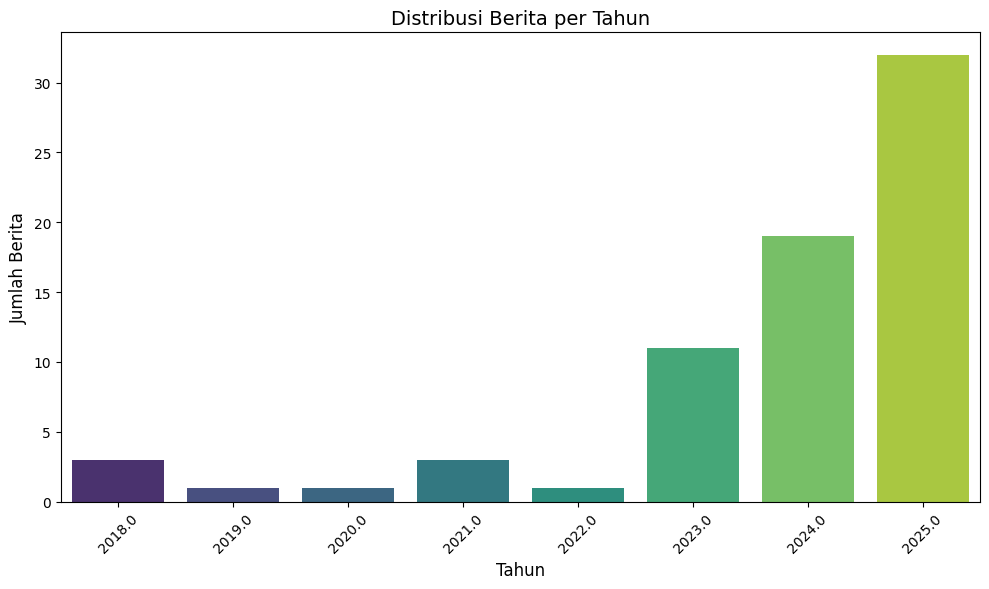

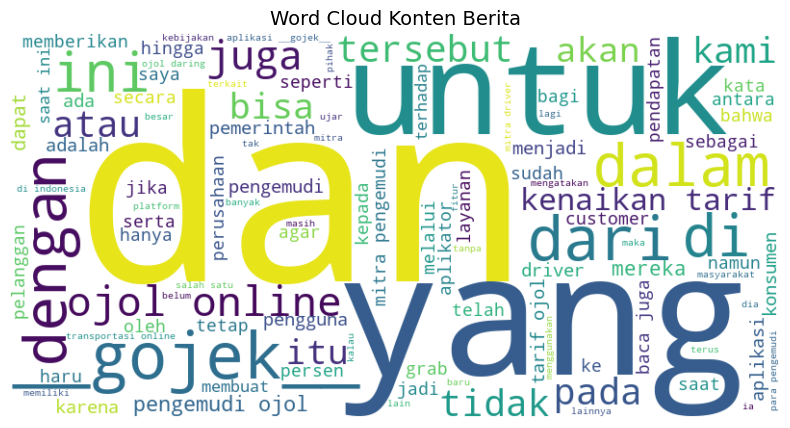

2025-10-28 15:58:36,225 - INFO - Jumlah kemunculan 'gojek' di kolom 'content': 0
2025-10-28 15:58:36,225 - INFO - Jumlah kemunculan 'gojek' di kolom 'judul': 0
2025-10-28 15:58:36,286 - INFO - Data disimpan ke gojek_news_preprocessed_before_augmentation.csv dan .xlsx
2025-10-28 15:58:36,286 - INFO - Jumlah data akhir: 143 (dari awal 177)
2025-10-28 15:58:36,286 - INFO - Sampel 5 baris pertama setelah preprocessing:
2025-10-28 15:58:36,287 - INFO -                                                                              judul                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [21]:
# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=berita_per_tahun.index, y=berita_per_tahun.values, palette='viridis')
plt.title('Distribusi Berita per Tahun', fontsize=14)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Berita', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('berita_per_tahun.png')
plt.show()

# Word Cloud
wordcloud_text = ' '.join(gojek_news_df['cleaned_content'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS, min_font_size=10).generate(wordcloud_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Konten Berita', fontsize=14)
plt.savefig('wordcloud_preprocessed.png')
plt.show()

# Hitung kemunculan gojek
jumlah_gojek_content = gojek_news_df['cleaned_content'].str.contains(r'\bgojek\b', case=False).sum()
jumlah_gojek_judul = gojek_news_df['judul'].str.contains(r'\bgojek\b', case=False).sum()
logger.info(f"Jumlah kemunculan 'gojek' di kolom 'content': {jumlah_gojek_content}")
logger.info(f"Jumlah kemunculan 'gojek' di kolom 'judul': {jumlah_gojek_judul}")

# Simpan hasil
gojek_news_df.to_csv('gojek_news_preprocessed_before_augmentation.csv', index=False)
gojek_news_df.to_excel('gojek_news_preprocessed_before_augmentation.xlsx', index=False)
logger.info(f"Data disimpan ke gojek_news_preprocessed_before_augmentation.csv dan .xlsx")
logger.info(f"Jumlah data akhir: {len(gojek_news_df)} (dari awal {initial_count})")

# Validasi sampel
logger.info("Sampel 5 baris pertama setelah preprocessing:")
logger.info(gojek_news_df[['judul', 'cleaned_content', 'tanggal']].head().to_string())